In [1]:
import os
import sys
import re
import json

import psycopg2 as pg

import numpy as np
import pandas as pd
from pandas import DataFrame as DF, Series

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

## Connect to DB

In [1]:
with open("../../elections_login.json", "rb") as f:
    login_info = json.load(f)

In [2]:
host = login_info["ip"]
dbname = login_info["db"]
username = login_info["username"]
password = login_info["password"]
db = pg.connect(host=host, dbname=dbname, user=username, password=password)
cur = db.cursor()

## Read Data

In [3]:
stmnt = pd.read_sql("select * from statement_of_org where candidate is not null", db)
ballots = pd.read_sql("select * from ballots", db)
tx = pd.read_sql("select * from transactions", db)
details = pd.read_sql(
    ("select transaction_id, address_book_type, name, amount, process_status, "
     "transaction_date, transaction_sub_type, transaction_type "
     "from transaction_details"),
    db)

ballots.loc[:, 'votes'] = ballots.votes.apply(lambda x: json.loads(x))

In [4]:
# Create total votes column

def toint(x):
    for k,v in x.items():
        if not v:
            x[k] = 0
        else:
            if type(v) == str:
                x[k] =int(re.sub(r',', '', v))
            elif type(v) not in [int, float]:
                print(x)
    return x

ballots.votes.apply(lambda x: toint(x)).iloc[0]

ballots['total_votes'] = ballots.votes.apply(lambda x: Series(x).sum())

In [5]:
# merge ballots and statement
bal_stmnt = ballots.merge(stmnt, how='inner', on='candidate', suffixes=['_b', '_s'])
# merge tx and details
trans = tx.merge(details, how='inner', on='transaction_id')
trans['transaction_date'] = pd.to_datetime(trans.transaction_date_x)
trans.drop(['transaction_date_x', 'transaction_date_y'], axis=1, inplace=True)

### Consolidate Variety of Races

In [6]:
race_map = {
    'ATTORNEY GENERAL': 'Attorney General',
    'ATTORNEY GENERAL-DEM': 'Attorney General',
    'ATTORNEY GENERAL-REP': 'Attorney General',
    'Attorney General': 'Attorney General',
    'Auditor CITY OF PORTLAND': 'Auditor City of Portland',
    'COMMISSIONER OF THE BUREAU OF LABOR AND INDUSTRIES': 
        'Commissioner of the Bureau of Labor and Industries',
    'Chair of the Board of Cty. Commissioners COMMISSIONER, AT LARGE': 
        'Chair of the Board of County Commissioners Commissioner At Large',
    'City of Portland Commissioner': 'City of Portland Commissioner',
    'City of Portland Mayor': 'City of Portland Mayor',
    'Commissioner of the Bureau of Labor and Ind.': 
        'Commissioner of the Bureau of Labor and Industries',
    'Commissioner, Bureau of Labor and Ind.': 
        'Commissioner of the Bureau of Labor and Industries',
    'Councilor METRO': 'Metro Councilor',
    'Councilor': 'Metro Councilor',
    'County Auditor': 'County Auditor',
    'GOVERNOR': 'Governor',
    'GOVERNOR-DEM': 'Governor',
    'GOVERNOR-REP': 'Governor',
    'JUDGE OF THE CIRCUIT COURT': 'Judge of the Circuit Court',
    'JUDGE OF THE COURT OF APPEALS': 'Judge of the Court of Appeals',
    'JUDGE OF THE SUPREME COURT': 'Judge of the Supreme Court',
    'METRO COUNCILOR': 'Metro Councilor',
    'Mayor CITY OF PORTLAND': 'City of Portland Mayor',
    'Metro Councilor': 'Metro Councilor',
    'Multnomah Co Commissioner': 'Multnomah County Commissioner',
    'PORTLAND CITY COMMISSIONER': 'City of Portland Commissioner',
    'REPRESENTATIVE IN CONGRESS': 'United States Congress Representative',
    'SECRETARY OF STATE': 'Secretary of State',
    'SECRETARY OF STATE-REP': 'Secretary of State',
    'STATE REPRESENTATIVE': 'State Representative',
    'STATE SENATOR': 'State Senator',
    'STATE TREASURER': 'State Treasurer',
    'STATE TREASURER-DEM': 'State Treasurer',
    'State Treasurer': 'State Treasurer',
    'UNITED STATES SENATOR-REP': 'United States Senator',
    'DISTRICT ATTORNEY': 'Multnomah County District Attorney',
    'District Attorney, Multnomah County': 'Multnomah County District Attorney',
}

In [7]:
# races not in race_map will be null
# but we don't care about those
bal_stmnt.loc[:, 'race'] = bal_stmnt.race.map(race_map)

In [8]:
# date ranages
# primary = ['11-07', '05-06']
# general = ['05-07', '11-06']

### Money over time

In [9]:
# Transaction types for money in/out

intypes = [
    'Contribution',
    'Other Receipt',
    'Other Account Receivable',
    
]

outtypes = [
    'Expenditure',
    'Other Disbursement',
#     'Other',
]

# Get subset for just 2012-2013
y1213 = trans[trans.transaction_date.dt.year.isin(range(2012,2014))]
# separate into in/out money
y1213_in = y1213[y1213.transaction_type.isin(intypes)].copy()
y1213_out = y1213[y1213.transaction_type.isin(outtypes)].copy()

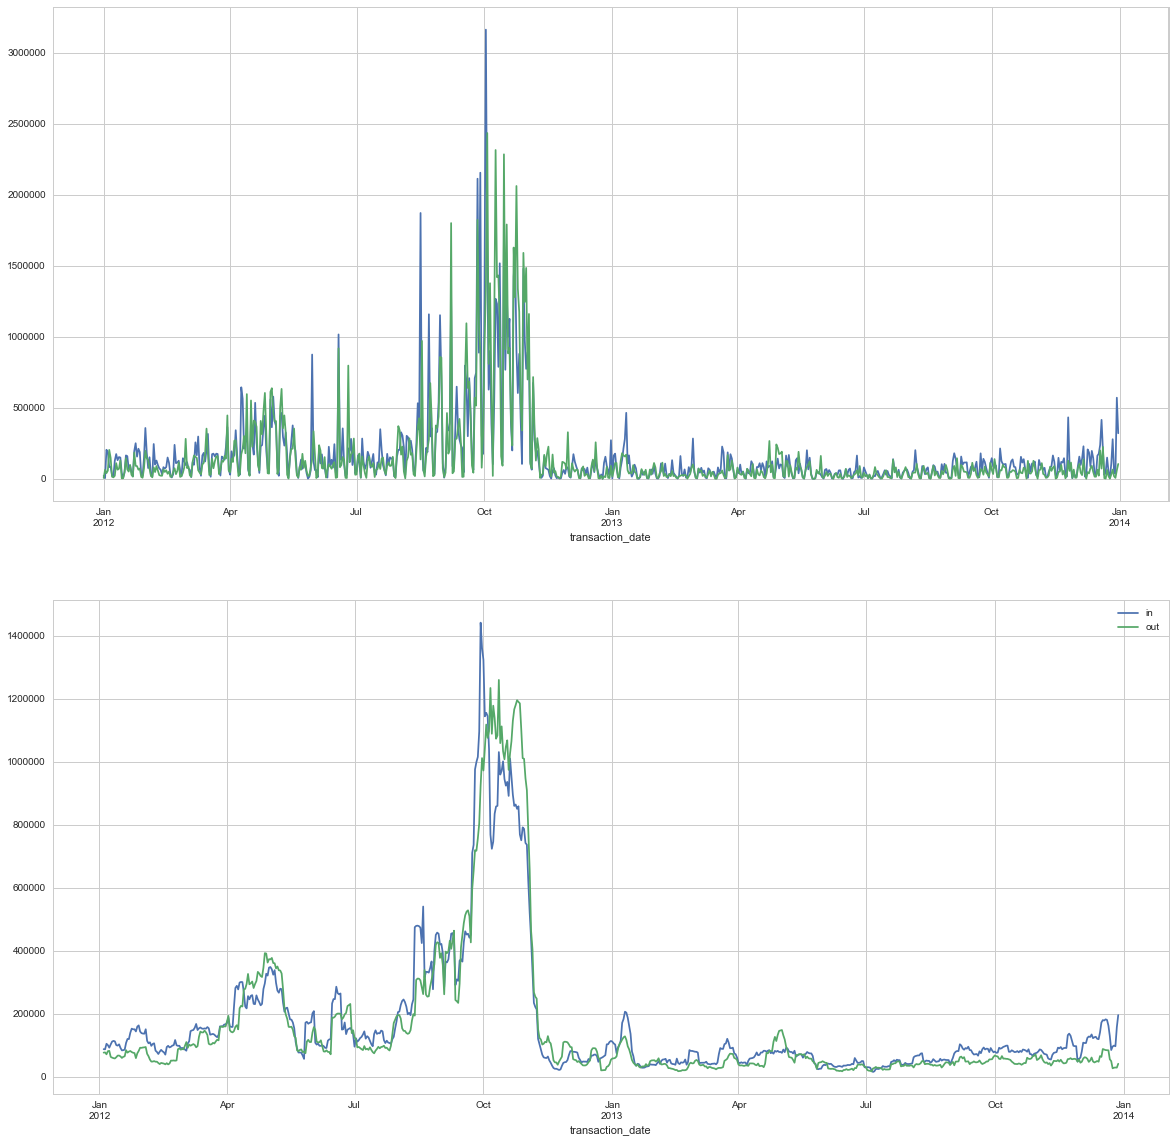

In [10]:
decomp_in = seasonal_decompose(
    y1213_in.fillna(0).groupby('transaction_date').amount_x.sum(),
    
)

decomp_out = seasonal_decompose(
    y1213_out.fillna(0).groupby('transaction_date').amount_x.sum(),
    
)

fig, axs = plt.subplots(2,1, figsize=(20,20))
decomp_in.observed.plot(ax=axs[0])
decomp_in.trend.plot(ax=axs[1], label='in')
decomp_out.observed.plot(ax=axs[0])
decomp_out.trend.plot(ax=axs[1], label='out')
plt.legend();
# decomp.seasonal.plot(ax=axs[2])
# decomp.resid.plot(ax=axs[3]);

### Data Munging

In [11]:
# See comments in next cell (with group_ funcs)
    
def primary_or_general(x):
    m = x.month
    d = x.day
    if ((m == 11) & (d > 7)) | (m > 11):
        # it's primary
        return 'P'
    elif ((m == 5) & (d < 6)) | (m < 5):
        return 'P'
    return 'G'

In [12]:
def get_in_out_trans():
    # mods global var -- no need to return value
    trans['expenditure'] = trans.transaction_type.isin(outtypes)

# group by election year (e.g. Nov 7 2012 - Nov 6 2013) is 2013 elec year
def group_elec_year(df):
    return df.groupby(df.transaction_date.apply(lambda x: bin_year(x)))


#---vv Currently Unused vv---#

# group by primary/general elections (based on date ranges)
def group_pg(df):
    return df.groupby(df.transaction_date.apply(lambda x: primary_or_general(x)))

In [13]:
# Creates column in trans DF with Boolean indicator of expenditure [= True]
get_in_out_trans()

In [14]:
# Create column to indicate election year
# trans['year'] = trans.transaction_date.apply(lambda x: x.year)
# trans['election_year'] = trans.transaction_date.apply(lambda x: bin_year(x))
# trans['election_type'] = trans.transaction_date.apply(lambda x: primary_or_general(x))

In [15]:
# save changes to csv
# !!! required if you use merge_chunk() below !!!
trans.to_csv('trans.csv', index=False)

## Get Total Money by Candidate & Race

In [16]:
# Merge trans and bal_stmnt DFs on committee_id

# !!! Be sure to delete merged.csv if you have run this already !!!

# merge by chunking if the process is too much for memory
def merge_chunk(chunk, header):
    df = bal_stmnt.merge(
        chunk,
        how='inner',
        left_on=['committee_id'],
        right_on=['committee_id']
    )
    # appends to merged.csv
    df.to_csv('merged.csv', mode='a', header=header, index=False)
    
# adjust chunk size if necessary
reader = pd.read_csv('trans.csv', chunksize=50000)

# only set header=True if first chunk
[merge_chunk(c, i==0) for i,c in enumerate(reader)];

In [17]:
# Read in the merged data

merged = pd.read_csv('merged.csv')
merged.rename(columns={'amount_x':'amount'}, inplace=True)
merged.loc[:, 'transaction_date'] = pd.to_datetime(merged.transaction_date)

# the mixed types warning should be fine (from null values in string columns I believe)

/Users/michaelcrown/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24,25,31,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Map Consolidated Races to Lists of Election Years

In [18]:
election_years = {
    'Governor': [2006, 2010, 2014, 2018],
    'State Representative': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'State Senator': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'Attorney General': [2004, 2008, 2012, 2016, 2020],
    'Secretary of State': [2004, 2008, 2012, 2016, 2020],
    'State Treasurer': [2004, 2008, 2010, 2012, 2016, 2020],
    'Commissioner of the Bureau of Labor and Industries': [2006, 2008, 2014, 2018],
    'Judge of the Circuit Court': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'Judge of the Court of Appeals': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'Judge of the Supreme Court': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'Metro Councilor': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'City of Portland Commissioner': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'City of Portland Mayor': [2004, 2008, 2012, 2016, 2020],
    'Auditor City of Portland': [2006, 2010, 2014, 2018],
    'Chair of the Board of County Commissioners Commissioner At Large': [2006, 2010, 2014, 2018],
    'Multnomah County Commissioner': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'County Auditor': [2006, 2010, 2014, 2018],
    'Multnomah County District Attorney': [2004, 2008, 2012, 2016, 2020],
    'United States Congress Representative': [2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018],
    'United States Senator': [2004, 2008, 2010, 2014, 2016, 2020],
}

In [19]:
# Map transaction date to election year

def txdate_to_elecyear(r, election_years):
    date = r['transaction_date']
    race = r['race']
    if race not in election_years:
        return None
    years = election_years[race]
    
    lteq = (np.array([date.year]) <= np.array(years))
    eq = (np.array([date.year]) == np.array(years))
    if not lteq.any():
        print(date)
        return None
    
    idx = lteq.argmax()
    if eq.any():
        eqid = eq.argmax()
    else:
        eqid = -1
    if (date.month >= 11) & (date.day > 6):
        # belongs to next primary
        if idx == eqid:
            return years[idx + 1]
        return years[idx]
    else:
        # next election year if idx != eqid
        # current year if idx == eqid
        return years[idx]

In [20]:
# this will take a couple minutes on laptop
merged['election_year'] = merged.apply(lambda r: txdate_to_elecyear(r, election_years), axis=1)

In [21]:
# Create a smaller "high frequency" DF containing only candidates
# who have participated in 2 or more elections

candidates = ballots.groupby('candidate').year.nunique()[
    ballots.groupby('candidate').year.nunique() > 1  # participation
].index.tolist()

merged_hf = merged[merged.candidate.isin(candidates)].copy()

In [22]:
# This number will be reduced below
merged_hf.shape

(1010094, 52)

In [23]:
# keep only records where election year matches the ballot year
merged_hf = merged_hf[merged_hf.year == merged_hf.election_year]
merged_hf.shape

(241637, 52)

## Amount vs Votes 

In [24]:
# Map each race to a type/category
race_type_map = {
    'State Representative': 'State Legislature',
    'State Senator': 'State Legislature',
    'State Treasurer': 'Statewide Races',
    'Commissioner of the Bureau of Labor and Industries': 'Statewide Races',
    'Governor': 'Statewide Races',
    'City of Portland Mayor': 'Portland and Multnomah County',
    'City of Portland Commissioner': 'Portland and Multnomah County',
    'Chair of the Board of County Commissioners Commissioner At Large': 'Portland and Multnomah County',
    'Judge of the Court of Appeals': 'Other',
    'United States Senator': 'State Legislature',
    'Multnomah County Commissioner': 'Portland and Multnomah County',
    'Multnomah County District Attorney': 'Portland and Multnomah County',
    'Metro Councilor': 'Portland and Multnomah County',
    'Auditor City of Portland': 'Portland and Multnomah County',
    'Judge of the Circuit Court': 'Other',
    'County Auditor': 'Portland and Multnomah County',
    'Attorney General': 'Statewide Races',
    'Judge of the Supreme Court': 'Statewide Races',
    'Secretary of State': 'State Legislature',
    'United States Congress Representative': 'Federal',
}

In [25]:
# Create column with consolidated race names
merged_hf['race_type'] = merged_hf.race.map(race_type_map)

In [26]:
set(merged_hf.race_type)

{'Federal',
 'Other',
 'Portland and Multnomah County',
 'State Legislature',
 'Statewide Races'}

### Scatter Plot by Race (spend vs Votes)

These are easily changed to analyze race type/category instead of Race: just change the groupby

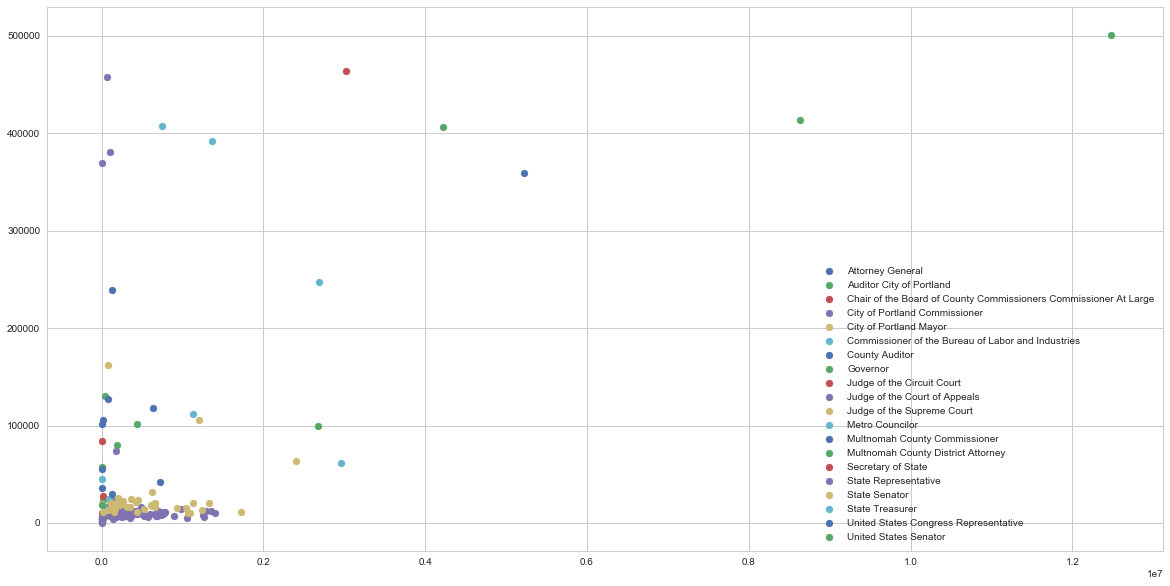

In [27]:
spend = merged_hf[merged_hf.expenditure == True].copy()

g1 = spend.groupby(['candidate','race', 'election_year'])['amount','total_votes']
amnt_votes = g1.agg({'amount': np.sum, 'total_votes': np.mean})

g2 = amnt_votes.reset_index().groupby('race')

fig, ax = plt.subplots(figsize=(20,10))
for n,g in g2:
    ax.scatter(g.amount, g.total_votes, label=n)
ax.legend();

### Regression Plots by Race (Spend vs Votes)

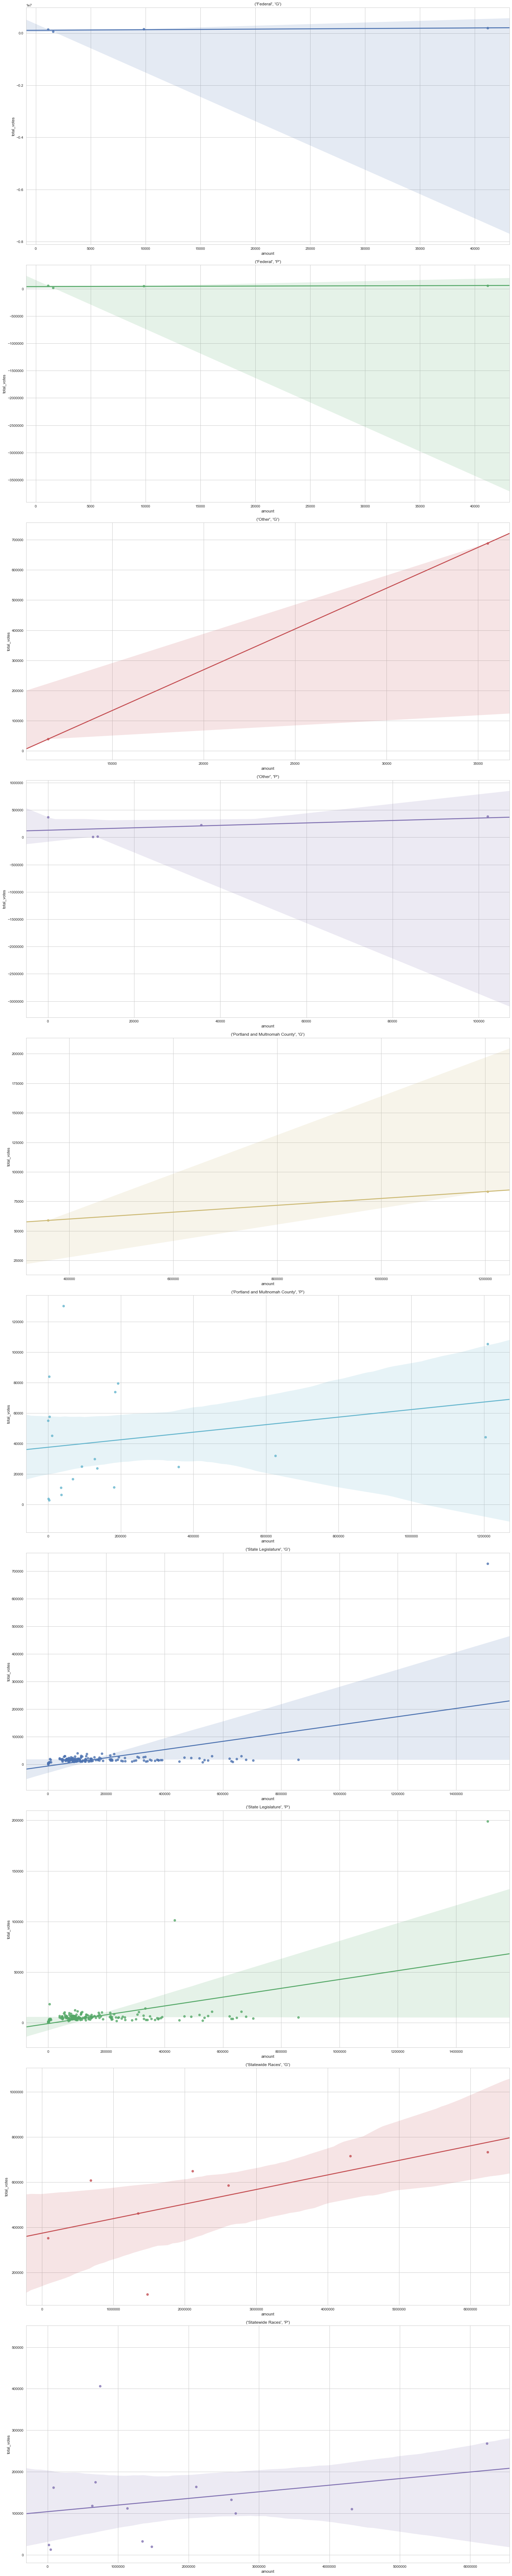

In [28]:
spent = merged_hf[merged_hf.expenditure == True].copy()
# Most of these have very few data points

g1 = spent.groupby(['candidate','race_type', 'election_year', 'type'])['total_votes', 'amount']
amnt_votes = g1.agg({'amount': np.sum, 'total_votes': np.mean})

g2 = amnt_votes.reset_index().groupby(['race_type', 'type'])

nplots = len(g2.sum())
fig, ax = plt.subplots(nplots, 1, figsize=(20,100))
for i, (n,g) in enumerate(g2):
    sns.regplot(g.amount, g.total_votes, label=n, ax=ax[i])
    ax[i].set_title(n)
plt.tight_layout();

### Money In (Raised)

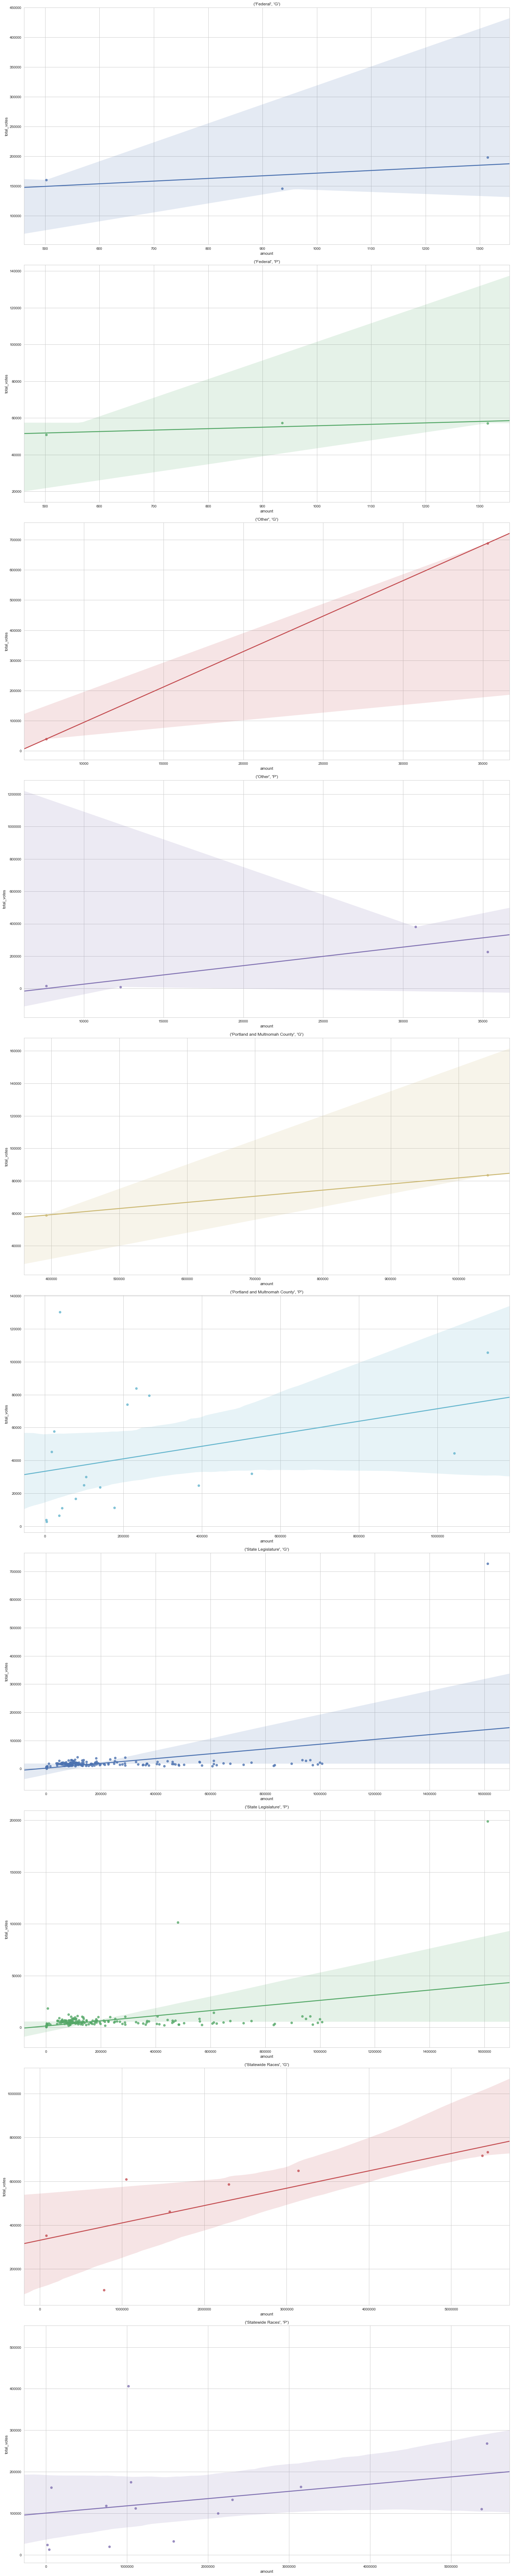

In [29]:
# np.random.seed(123)  # ensure same color order
raised = merged_hf[merged_hf.expenditure == False].copy()

g1 = raised.groupby(['candidate','race_type', 'election_year', 'type'])['total_votes', 'amount']
amnt_votes = g1.agg({'amount': np.sum, 'total_votes': np.mean})

g2 = amnt_votes.reset_index().groupby(['race_type', 'type'])

nplots = len(g2.sum())
fig, ax = plt.subplots(nplots, 1, figsize=(20,100))
for i, (n,g) in enumerate(g2):
    sns.regplot(g.amount, g.total_votes, label=n, ax=ax[i])
    ax[i].set_title(n)
plt.tight_layout();

## Voter Acquisition

Because there is no relationship between spend and votes, there will be no significant relationship between voter acquisition and total votes, but feel
free to explore what is below.

In [30]:
# Create column for price per vote
g1 = spent.groupby(['candidate','race', 'election_year', 'type'])['total_votes', 'amount']
acq = g1.agg({'amount': np.sum, 'total_votes': np.mean})
acq = acq.apply(
    lambda r: Series(
        {'voter_acq': r['amount']/r['total_votes'],
         'total_votes': r['total_votes']}),
    axis=1)

In [31]:
acq.head()

total_votes  voter_acq
candidate    race          election_year type                        
Alan C Bates State Senator 2010.0        G         24550.0  12.671664
                                         P         10714.0  29.035779
                           2014.0        G         27667.0  12.040883
                                         P         14155.0  23.534802
Alan R Olsen State Senator 2010.0        G         23044.0   3.504052

In [32]:
acq.idxmax()

total_votes           (John Kitzhaber, Governor, 2014.0, G)
voter_acq      (Dan Mason, State Representative, 2014.0, P)
dtype: object

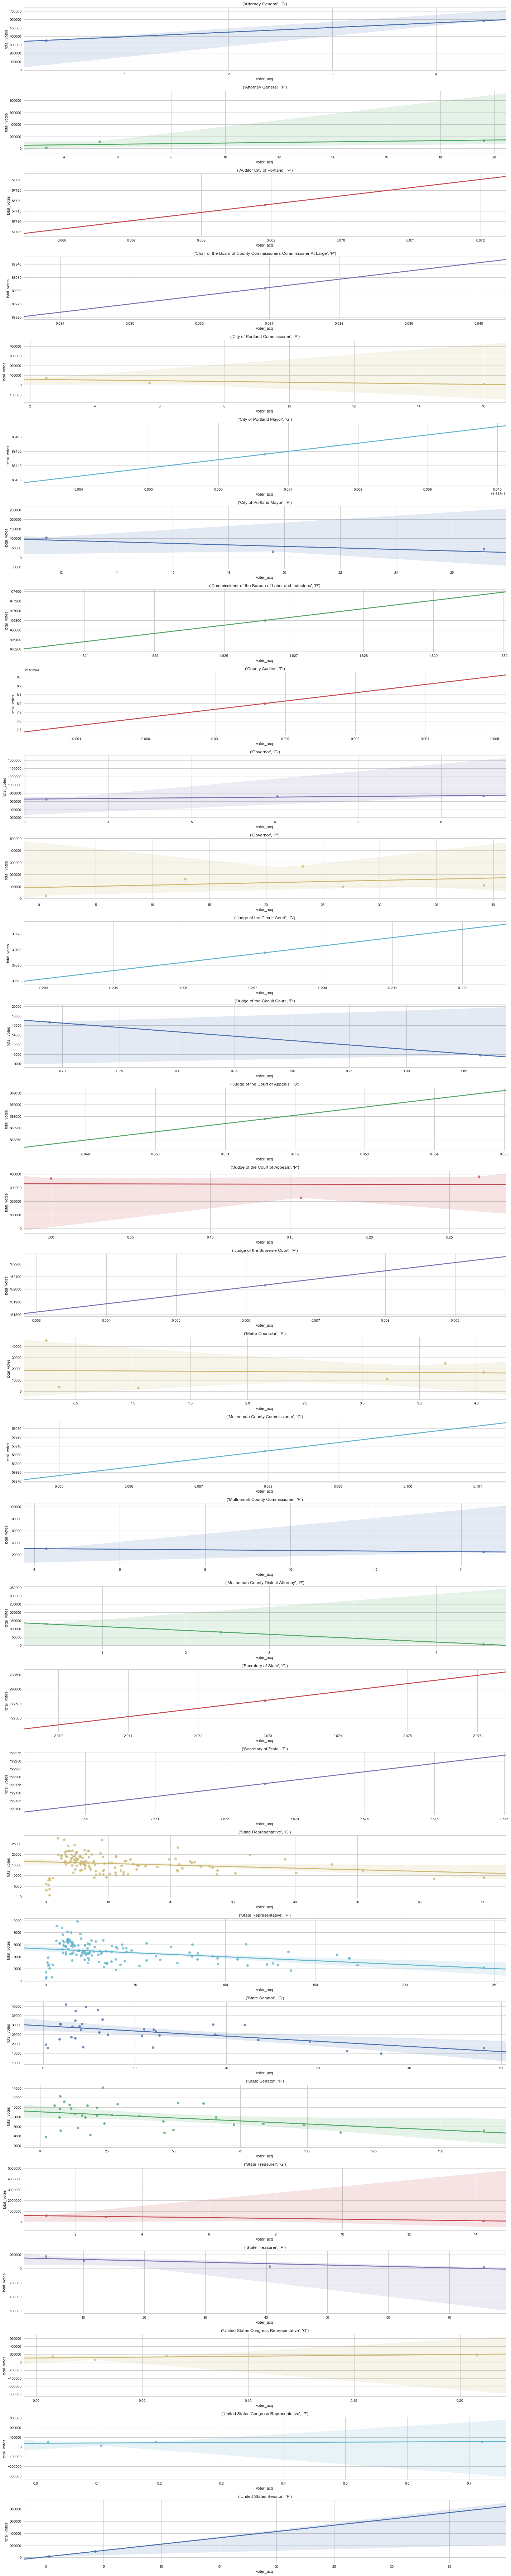

In [33]:
g2 = acq.reset_index().groupby(['race', 'type'])

nplots = len(g2.sum())
fig, ax = plt.subplots(nplots, 1, figsize=(20,100))
for i, (n,g) in enumerate(g2):
    sns.regplot(g.voter_acq, g.total_votes, label=n, ax=ax[i])
    ax[i].set_title(n)
plt.tight_layout();

## Influential Donors

In [34]:
# Get only data for races that contained at least two candidates

multi_candidate = merged_hf.groupby(['race','year','district']).candidate.nunique().copy()
multi_candidate = multi_candidate[multi_candidate > 1]

multi_candidate = merged_hf.merge(
    multi_candidate.reset_index(), on=['race','year','district'], how='inner')
multi_candidate.rename(columns={'candidate_x': 'candidate'}, inplace=True)
multi_candidate.drop('candidate_y', axis=1, inplace=True)

In [35]:
# Create DF containing column for whether or not candidate won
# for each race, in both primary and general.

by_race = multi_candidate.groupby(['race','year','district','candidate','type']).apply(
    lambda x: Series({'won': np.mean(x['won'])}))
by_race.reset_index().groupby(['race','year','district','type']).won.mean().describe()

count    50.000000
mean      0.716667
std       0.265666
min       0.000000
25%       0.500000
50%       0.500000
75%       1.000000
max       1.000000
Name: won, dtype: float64

In [36]:
by_race.head()

won
race                   year district candidate        type     
Attorney General       2012 -        Ellen Rosenblum  G     1.0
                                                      P     1.0
                                     James L Buchal   G     0.0
                                                      P     1.0
City of Portland Mayor 2016 -        Jules L K Bailey P     0.0

In [37]:
# Assign 1 to a single record for the winner of each race (P and G separate)

idxs = multi_candidate.groupby(['race','year','district','type']).total_votes.idxmax()
multi_candidate['winner'] = 0
multi_candidate.loc[idxs, 'winner'] = 1

In [38]:
# Maximum number of candidates in a race we have data for
multi_candidate.groupby(['race','year','district','type']).apply(
    lambda x: Series(
        {
            'n_candidates': x['candidate'].nunique(),
        }
    )
).max()

n_candidates    3
dtype: int64

Only 3... It's possbile there are candidates missing due to lack of transaction data overlap.
Someone should probably spot check by cross-referncing with the ballots data on certain races,
to see if we have the right winners. There were enough canididates indicated as winners
in the "won" column from the original "merged" DF, that I'm pretty sure it's fine.

In [39]:
winners = multi_candidate[multi_candidate.won == 1][['race','year','district','type','candidate']]
winners.drop_duplicates(inplace=True)
winners.head()

,race,year,district,type,candidate
0,State Representative,2012,34TH DISTRICT,G,Chris Harker
288,State Representative,2012,34TH DISTRICT,P,Chris Harker
899,State Representative,2012,34TH DISTRICT,P,Dan Mason
5761,Governor,2014,-,P,Dennis M Richardson
10300,Governor,2014,-,G,John Kitzhaber


In [40]:
# Get win rates for contributors

# indicates if candidate is winner for each contributor and race
contributors = multi_candidate.groupby(
    ['contributor_payee', 'race','year','district','type','candidate']
).won.max()

# compute the win rates for each contributor
win_rates = contributors.reset_index().groupby('contributor_payee').apply(
    lambda x: Series({
        'win_rate': x['won'].mean(),
    })
)

# create a column to show how many races a contributor gave to
counts = contributors.reset_index().groupby('contributor_payee').size()
win_rates = win_rates.join(DF(counts)).rename(columns={0: 'n_races'})

#### Finally get win rates for donors

In [41]:
win_rates.sort_values(by=['win_rate', 'n_races'], ascending=False).head()

,win_rate,n_races
contributor_payee,,
IBEW Educational Committee **,1.0,14
Oregon School Employees Assoc. - Voice of Involved Classified Employees (2307),1.0,14
Planned Parenthood PAC of Oregon (4327),1.0,13
"Capitol Dental Care, Inc.",1.0,12
"Castle Rock Farming, LLC",1.0,12


In [42]:
win_rates[(win_rates.win_rate == 1) & (win_rates.n_races >= 11)]

,win_rate,n_races
contributor_payee,,
"Capitol Dental Care, Inc.",1.0,12
"Castle Rock Farming, LLC",1.0,12
Henry Hewitt,1.0,11
IBEW Educational Committee **,1.0,14
John Coletti,1.0,12
Oregon School Employees Assoc. - Voice of Involved Classified Employees (2307),1.0,14
Planned Parenthood PAC of Oregon (4327),1.0,13
Safety and Justice PAC (15022),1.0,12
Willamette Women Democrats PAC (5534),1.0,12


In [60]:
multi_candidate[multi_candidate.contributor_payee.isin(
    win_rates[(win_rates.win_rate == 1) & (win_rates.n_races >= 5)].index)
               ].groupby(['race','district','year','contributor_payee']).candidate.nunique().head()

race              district  year  contributor_payee               
Attorney General  -         2012  Alice Bartelt                       1
                                  American Beverage Association **    1
                                  Apollo Group, Inc. **               1
                                  Carol Lewis                         1
                                  Charles Swindells                   1
Name: candidate, dtype: int64

## Primary Predictive?

In [44]:
# Create a DF that contains only races where there
# were at least 2 candidates in the Primary and General

candidate_counts = multi_candidate.groupby(['race', 'year','district', 'type']).apply(
    lambda x: Series({'n': x['candidate'].nunique() > 1}))

hf_mask = candidate_counts.unstack()[
    candidate_counts.unstack().sum(axis=1) > 1
].reset_index()[['race','year','district']]
hf_mask.columns = hf_mask.columns.droplevel(1)

hf_races = multi_candidate.merge(hf_mask, how='inner', on=['race','year','district'])
hf_races.shape

(59063, 54)

In [45]:
# Equals 2 if won P and G;
# Equals 1 if P or G but not both
primary_general = hf_races.groupby(
    ['race','year','district','candidate','type']
).won.max().unstack().sum(axis=1)

primary_general.head()

race              year  district  candidate          
Attorney General  2012  -         Ellen Rosenblum        2.0
                                  James L Buchal         1.0
Governor          2014  -         Bruce Cuff             0.0
                                  Dennis M Richardson    1.0
                                  John Kitzhaber         2.0
dtype: float64

In [46]:
primary_votes = multi_candidate[multi_candidate.type == 'P'].groupby(
    ['race','year','district','type']
).total_votes.max().reset_index()

In [47]:
best_primary = multi_candidate.merge(
    primary_votes, on=['race','year','district','total_votes'],
    how='left', suffixes=['', '_won'])#.groupby(['race','year','district']).candidate.nunique()

In [48]:
best_primary.type_won.value_counts()

P    28118
Name: type_won, dtype: int64

In [49]:
best_primary['most_votes_primary'] = best_primary.type_won == 'P'

In [50]:
best_primary = best_primary.groupby(['race','year','district','candidate']).most_votes_primary.max().reset_index()

In [51]:
multi_candidate = multi_candidate.merge(best_primary, on=['race','year','district','candidate'], how='left')

#### How often does primary win the general?

In [52]:
primary_general = multi_candidate[multi_candidate.type == 'G'].groupby(
    ['race','year','district','most_votes_primary']).won.max().unstack()

DF(primary_general.mean())

,0
most_votes_primary,
False,0.090909
True,0.916667


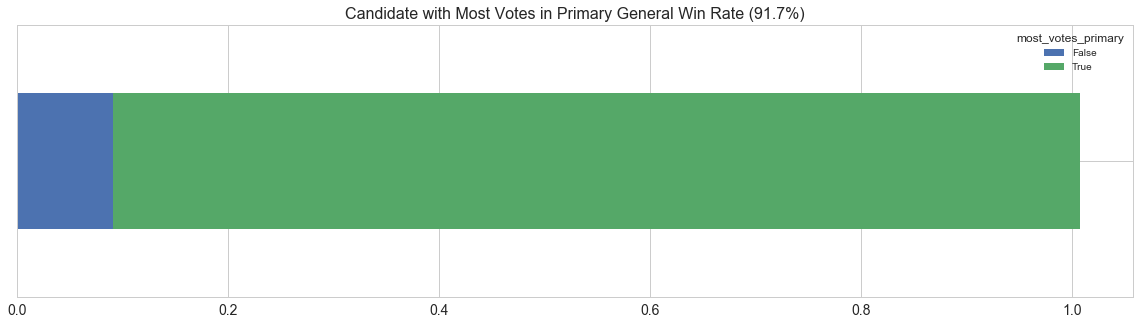

In [53]:
fig = DF(primary_general.mean()).T.rename(index={0:''}).plot.barh(
    figsize=(20,5),
    fontsize=14,
    stacked=True,
)
fig.set_title('Candidate with Most Votes in Primary General Win Rate (91.7%)', fontsize=16)
fig.set_ylabel('', fontsize=16);

Candidate with most votes in primary wins general 91.7% of the time.

## Grass Roots

In [54]:
multi_candidate['grassroots'] = (multi_candidate.name == 'Miscellaneous Cash Contributions $100 and under').astype(int)

In [55]:
gcounts = multi_candidate.apply(lambda r: r['grassroots']*(max(1,r['amount']//65) - 1) + 1, axis=1)
multi_candidate['groot_counts'] = gcounts

In [56]:
gcounts.describe(percentiles=[0.98])

count    81418.000000
mean         1.395969
std          3.896271
min          1.000000
50%          1.000000
98%          5.000000
max        214.000000
dtype: float64

In [57]:
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q
from scipy.stats import fisher_exact, chi2_contingency as chi2

In [58]:
dedup = multi_candidate.sort_values(by='won', ascending=False)
dedup = dedup.drop_duplicates(subset=['candidate','race','type','district','year'])

# This doesn't take aggregates within one record into account
# e.g. one record can have more than one contribution aggregated
# for amount.
contingency = pd.crosstab(dedup.grassroots, dedup.won)
contingency

won,0,1
grassroots,,
0,25,63
1,4,6


In [59]:
fisher_exact(contingency)

(0.5952380952380952, 0.47613573190766734)

In [74]:
# twoway is treating contributed dollars as counts
twoway = multi_candidate[
    ~multi_candidate.expenditure
].groupby(['grassroots','won']).amount.sum().unstack()

twoway

won,0,1
grassroots,,
0,10594448.07,49421727.33
1,543950.39,2161325.95


In [75]:
# percentage of dollars contibuted to winners & losers
# from grassoots & non-grassoots (each row sums to 100)
twoway_counts = round(twoway.divide(twoway.sum(axis=1), axis=0)*100).astype(int)
twoway_counts

won,0,1
grassroots,,
0,18,82
1,20,80


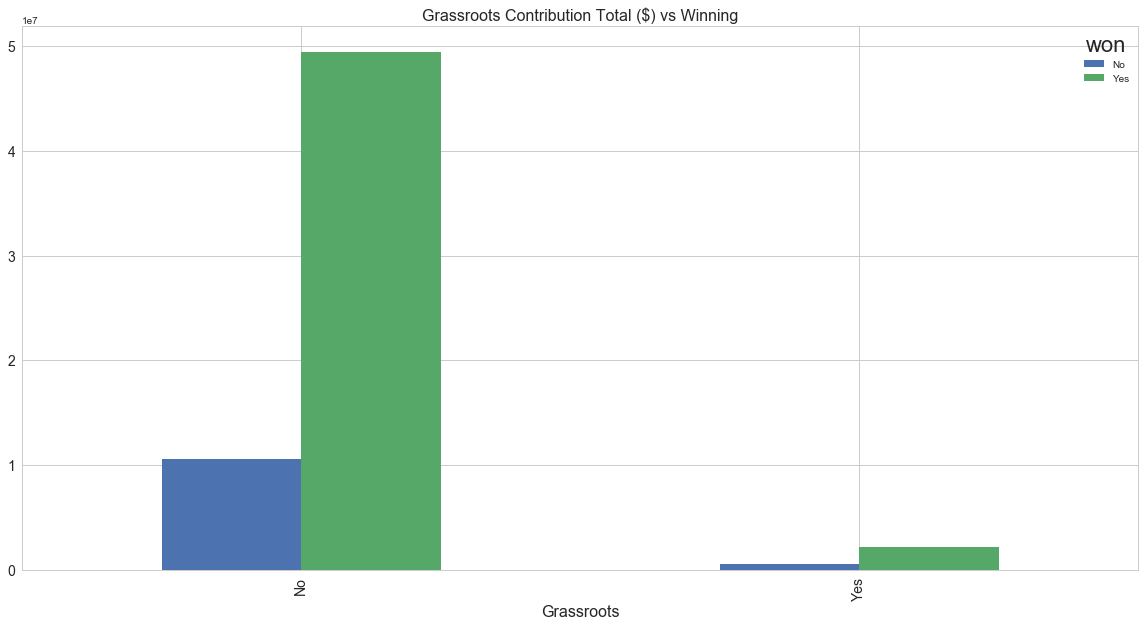

In [76]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})

fig = twoway.rename(index={0:'No', 1:'Yes'}, columns={0:'No', 1:'Yes'}).plot.bar(
    figsize=(20,10),
    fontsize=14,
)
fig.set_title('Grassroots Contribution Total ($) vs Winning', fontsize=16)
fig.set_xlabel('Grassroots', fontsize=16);

In [77]:
chi2(twoway_counts)

(0.03248862897985705, 0.8569594285548041, 1, array([[19., 81.],
        [19., 81.]]))

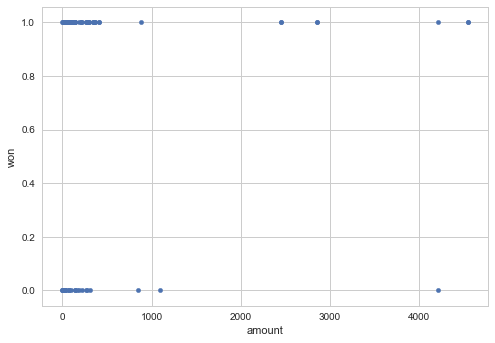

In [78]:
# groots = multi_candidate[multi_candidate.name == 'Miscellaneous Cash Contributions $100 and under']
groots = multi_candidate.groupby(['race','year','district','candidate','type','name','won']).amount.sum()//65
groots = groots.reset_index()#.rename(columns={0: 'count'})
groots[(groots.name == 'Miscellaneous Cash Contributions $100 and under')].plot.scatter('amount', 'won');

In [79]:
multi_candidate.year.value_counts()

2012    26620
2014    26519
2010    24562
2016     3717
Name: year, dtype: int64

## Spending Patterns

In [80]:
set(details[details.transaction_type == 'Expenditure'].transaction_sub_type)

{'Account Payable',
 'Cash Expenditure',
 'Expenditure Made by an Agent',
 'Loan Payment (Non-Exempt)',
 'Personal Expenditure for Reimbursement'}

In [81]:
expenditures = multi_candidate[multi_candidate.expenditure == True]

In [82]:
expenditures.groupby(['candidate','race','district','year','type']).amount.sum().describe()

count    9.800000e+01
mean     5.322371e+05
std      1.138740e+06
min      1.686500e+02
25%      5.756075e+04
50%      1.763495e+05
75%      4.458904e+05
max      6.238902e+06
Name: amount, dtype: float64

In [83]:
def get_top_spending(race):
    top_spending = expenditures[expenditures.race == race].groupby(
        'name'
    ).apply(lambda x: Series({
        'amount': x['amount'].median(),
        'n_candidates': x['candidate'].nunique()
    })).sort_values(by=['n_candidates','amount'], ascending=False)

    return top_spending[top_spending.amount > 500]

In [84]:
top_spend = set()
for race in set(expenditures.race):
    top_spend.update(set(get_top_spending(race).head(25).index))

In [85]:
len(top_spend)

130

In [87]:
list(top_spend)[:10]

['a-political',
 'Disneyland Resort',
 'Patinkin Research Strategies LLC',
 'Fulcrum Political, LLC',
 'Media Analysis, Inc.',
 'Strategic Media Placement Inc.',
 'Friends of Arnie Roblan (4726)',
 'Media Placement Services',
 'Committee to Elect Sal Esquivel (4813)',
 'Senate Democratic Leadership Fund (1471)']

In [88]:
spending_patterns = expenditures.groupby(['won','name']).amount.median().unstack().fillna(0).T
spending_patterns.sort_values(by=0, ascending=False).head()

won,0,1
name,,
Strategic Media Placement Inc.,62843.75,62843.75
Sq1,41500.00,41500.00
"Astley Consulting Group, Inc",32037.00,32037.00
Bridgeview Press,30000.00,30000.00
Oregon Trial Lawyers Association PAC (39),20000.00,20000.00


**^INCOMPLETE^**

## Party Affiliation

In [89]:
multi_candidate.groupby(['race','party_affiliation']).won.mean().unstack()

party_affiliation,Democrat,Nonpartisan,Republican
race,,,
Attorney General,1.000000,NaN,0.333333
City of Portland Mayor,NaN,0.494754,NaN
Governor,1.000000,NaN,0.374721
State Representative,0.932390,0.000000,0.802723
State Senator,0.846055,NaN,0.577514
United States Senator,NaN,NaN,0.000000


In [90]:
party_ctab = pd.crosstab(dedup.party_affiliation, dedup.won)
party_ctab.loc[['Democrat', 'Republican']]

won,0,1
party_affiliation,,
Democrat,7,41
Republican,20,27


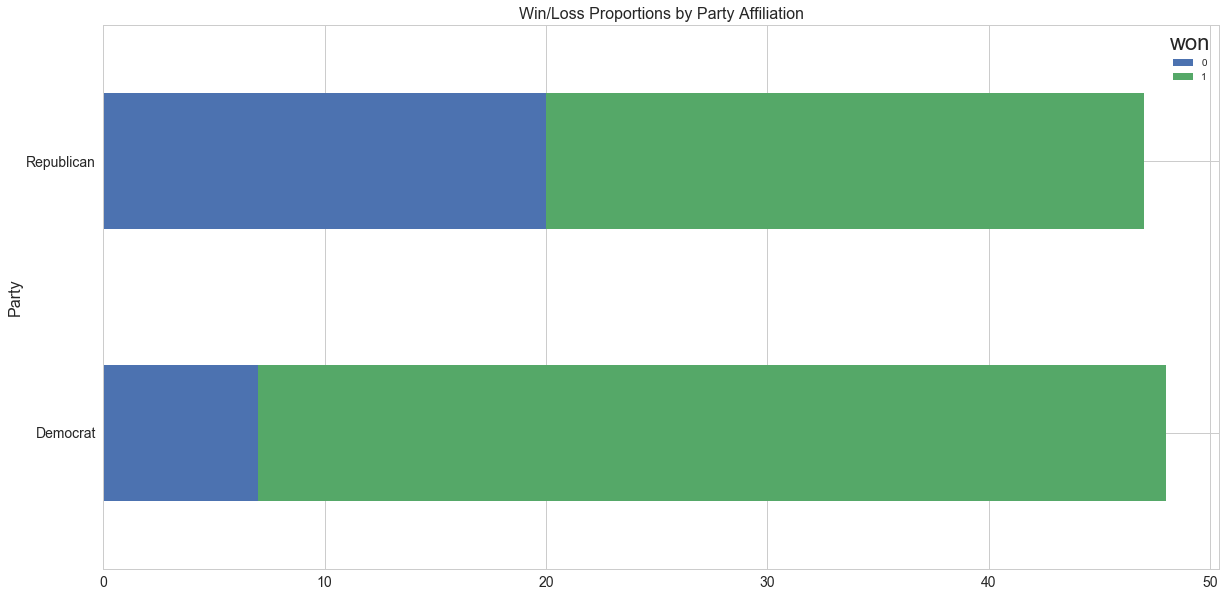

In [91]:
fig = party_ctab.loc[['Democrat', 'Republican']].plot.barh(
    figsize=(20,10),
    fontsize=14,
    stacked=True,
)
fig.set_title('Win/Loss Proportions by Party Affiliation', fontsize=16)
fig.set_ylabel('Party', fontsize=16);

In [92]:
fisher_exact(party_ctab.loc[['Democrat', 'Republican']])

(0.2304878048780488, 0.0031092249696658414)

In [93]:
chi2(party_ctab.loc[['Democrat', 'Republican']])

(7.808966394625225, 0.005198763094656112, 1, array([[13.64210526, 34.35789474],
        [13.35789474, 33.64210526]]))

## Feature Engineering

Engineer a data matrix `D` with features representing the componenents from all of the analysis above.

**Features**
* campaign expend
* campaign contrib
* influential donors
* primary/general (i.e. won primary indicator)
* voter aquisition in primary (optional)
* grassroots contribution total
* spending patterns (incomplete)
* party affiliation

**Data Format**
* One record per candidate per race per year
* Each record contains aggregates or values from features listed above

#### Create Datamatrix

In [94]:
keep = [
 'amount',
 'candidate',
 'contributor_payee',
 'district',
 'name',
 'party_affiliation',
 'race',
 'type',
 'won',
 'year',
 'expenditure',
 'most_votes_primary',
]

In [119]:
D = multi_candidate[keep].copy()

In [120]:
D.shape

(81418, 12)

In [121]:
# use for grouping and joining
gcols = ['candidate','race','district','year']

#### Expend

In [122]:
expend_feature = multi_candidate[multi_candidate.expenditure].groupby(gcols).amount.sum().reset_index()
expend_feature.head()

,candidate,race,district,year,amount
0,Allen H Alley,Governor,-,2010,2669640.03
1,Arnie Roblan,State Representative,9TH DISTRICT,2010,511611.66
2,Arnie Roblan,State Senator,5TH DISTRICT,2012,1124767.24
3,Brent Barton,State Representative,40TH DISTRICT,2012,503300.02
4,Brent Barton,State Representative,40TH DISTRICT,2014,377281.60


In [123]:
D = D.merge(expend_feature, on=gcols, suffixes=['','_expend'], how='left')

In [124]:
D.type.value_counts()

P    44735
G    36683
Name: type, dtype: int64

#### Contrib

In [125]:
contrib_feature = multi_candidate[~multi_candidate.expenditure].groupby(
    gcols).amount.sum().reset_index()
contrib_feature.head()

,candidate,race,district,year,amount
0,Allen H Alley,Governor,-,2010,2124680.39
1,Arnie Roblan,State Representative,9TH DISTRICT,2010,751146.36
2,Arnie Roblan,State Senator,5TH DISTRICT,2012,1927635.60
3,Brent Barton,State Representative,40TH DISTRICT,2012,1442127.48
4,Brent Barton,State Representative,40TH DISTRICT,2014,1667868.86


In [126]:
D = D.merge(contrib_feature, on=gcols, suffixes=['','_contrib'], how='left')

#### Influential Donors

**DO NOT USE**

In [404]:
infl_donors_list = win_rates[(win_rates.win_rate == 1) & (win_rates.n_races >= 5)].index.tolist()
infl_donors_list[:5]

['AAUP Portland State University Chapter',
 'Aflac Incorporated **',
 'Alice Bartelt',
 'American Beverage Association **',
 'Apollo Group, Inc. **']

In [405]:
infl_donors_feature = D[
    D.contributor_payee.isin(infl_donors_list)
    & (~D.expenditure)
].groupby(gcols).amount.sum().reset_index()

infl_donors_feature.head()

,candidate,race,district,year,amount
0,Arnie Roblan,State Representative,9TH DISTRICT,2010,25096.0
1,Arnie Roblan,State Senator,5TH DISTRICT,2012,144314.8
2,Brent Barton,State Representative,40TH DISTRICT,2012,52600.0
3,Brent Barton,State Representative,40TH DISTRICT,2014,18880.0
4,Chris Harker,State Representative,34TH DISTRICT,2012,10000.0


In [406]:
D = D.merge(infl_donors_feature, on=gcols, suffixes=['','_infl_contrib'], how='left')

D.type.value_counts()

P    44735
G    36683
Name: type, dtype: int64

#### Won Primary

In [378]:
# Already in data as most_votes_primary

#### Grassroots Contribution

In [127]:
groots_feature = multi_candidate[multi_candidate.grassroots == 1].groupby(gcols).amount.sum().reset_index()
groots_feature.head()

,candidate,race,district,year,amount
0,Allen H Alley,Governor,-,2010,55055.33
1,Arnie Roblan,State Representative,9TH DISTRICT,2010,27360.00
2,Arnie Roblan,State Senator,5TH DISTRICT,2012,36750.00
3,Brent Barton,State Representative,40TH DISTRICT,2012,17457.00
4,Brent Barton,State Representative,40TH DISTRICT,2014,6598.00


In [128]:
D = D.merge(groots_feature, on=gcols, suffixes=['','_groots'], how='left')

In [129]:
D.isnull().sum()

amount                 0
candidate              0
contributor_payee     17
district               0
name                  17
party_affiliation      0
race                   0
type                   0
won                    0
year                   0
expenditure            0
most_votes_primary     0
amount_expend          0
amount_contrib         0
amount_groots         18
dtype: int64

In [130]:
D.fillna({'amount_groots': 0}, inplace=True)

In [131]:
D.type.value_counts()

P    44735
G    36683
Name: type, dtype: int64

#### Party Affiliation

In [380]:
# Already in data as party_affiliation

#### One record per election/candidate (only want to predict General elections)

In [132]:
# results in one record per election & candidate
# agg of max doesn't matter: all values of interest
# are equal across similar records
D = D[D.type == 'G'].groupby(gcols).max().reset_index()

In [134]:
set(D)

{'amount',
 'amount_contrib',
 'amount_expend',
 'amount_groots',
 'candidate',
 'district',
 'expenditure',
 'most_votes_primary',
 'party_affiliation',
 'race',
 'type',
 'won',
 'year'}

In [138]:
keep = [
    'amount_contrib',
    'amount_expend',
    'amount_groots',
    'candidate',
    'district',
    'most_votes_primary',
    'party_affiliation',
    'race',
    'won',
]

In [139]:
D.to_csv('data_matrix_complete.csv', index=False)
D[keep].to_csv('data_matrix_modeling.csv', index=False)

## Misc

In [140]:
trans[
    trans.contributor_payee.isin(['Miscellaneous Cash Contributions $100 and under'])
    & (trans.amount_x > 500)
].groupby('committee_id').amount_x.describe().sort_values(by='50%', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
committee_id,,,,,,,,
4572,118.0,28915.904492,25591.394874,4010.51,10876.100,22325.030,37580.4350,158705.50
12987,111.0,16785.619459,3898.957359,10463.70,14687.405,16102.680,17868.9650,35685.80
12986,112.0,16731.690089,3923.636853,10463.70,14633.675,16092.435,17838.9825,35685.80
3816,43.0,14581.154419,5625.930520,8352.23,10253.055,13511.500,17208.1000,32769.15
3167,15.0,13089.294667,1816.546836,9811.33,11698.850,13369.710,14456.3350,16362.63
111,15.0,13087.793333,1816.242810,9811.33,11694.090,13368.710,14455.3350,16362.63
3094,7.0,21419.374286,15475.602749,6111.94,10126.755,12487.040,34655.7000,41771.73
17007,22.0,10360.388182,8027.360833,792.00,4168.880,9349.000,16847.9900,29413.20
16178,9.0,5791.926667,675.453188,4402.27,5542.850,6069.310,6116.4800,6595.14
